# Bayesian estimation of photosynthetic parameters in a Farquhar-von Caemmerer-Berry model

This note book illustrates how to run Bayesian inference for parameter estimation of a Farquhar-von Caemmerer-Berry (FvCB) model. Bayesian statistics estimate the posterior distribution of model parameters based on 1) input observations, 2) the process model and 3) prior information about each parameter.  
1) The **input data** needed for this notebook is concurrent measurements of net photosynthesis ($A_n$) and chlorophyll fluorescence ($Y(II)$) responses to Ci under several light levels  
2) The **model** used is the FvCB model for C3 leaf photosynthesis. $A_n$ and $Y(II)$ are function of $C_i$, $I$, $V_{cmax}$, $K_m$, $J$, $\Gamma^*$, $R_d$, $s$ and $g_m$.  

| Variables |  Definition  |  Units  |
|  :----:   |  :----:  |  :----:  |
|  $A_n$    |  Net photosynthesis rate  |  $\mu mol m^{-2} s^{-1}$  |
|  $Y(II)$  |  Quantum efficiency of absorbed photons by PSII  |  Unitless  |
|  $C_i$    |  Intercellular CO<sub>2</sub> partial pressure  |  $\mu bar$  |
|  $C_c$    |  Chloroplastic CO<sub>2</sub> partial pressure  |  $\mu bar$  |
|  $I$      |  Incident irradiance  |  $\mu mol m^{-2} s^{-1}$  |
|  $V_{cmax}$  |  CO<sub>2</sub> saturated Rubisco carboxylation rate  |  $\mu mol m^{-2} s^{-1}$  |
|  $K_m$    |  Michaelis-Menton constant of Rubisco for CO<sub>2</sub> in the presence of O<sub>2</sub>  |  $\mu bar$  |
|  $J$      |  Linear electron transport rate through PSII  |  $\mu mol m^{-2} s^{-1}$  |
|  $R_d$    |  Day respiration <br /> **- alternative name: Resp**  |  $\mu mol m^{-2} s^{-1}$  |
|  $\Gamma^*$  |  C<sub>c</sub>-based CO<sub>2</sub> compensation point in the presence of *$R_d$* <br /> **- alternative name: Gstar**  |  $\mu bar$  |
|  $\alpha$ |  Leaf absorptance  |  Unitless  |
|  $\beta$  |  Fraction of photons harvested by PSII on absorbed light basis, it accounts for alternative electron sinks and cyclic electron flow  |  Unitless  |
|  $s$      |  Product of $\alpha$ and $\beta$; a lumped parameter of light absorption and partition to PSII  |  Unitless  |
|  $g_m$    |  Mesophyll conductance  |  $mol m^{-2} s^{-1} bar^{-1}$  |

<img src="./pic/FvCBmodel.png" alt="Drawing" style="width: 350px;"/>
  
  
3) Noninformative uniform distribution is used as **prior** to estimate each parameter  
  
  
The Markov chain Monte Carlo (MCMC) method was used to approximate the joint posterior distribution in Bayesian estimation. The MCMC method is implemented in the software package JAGS (Just Another Gibbs Sampler). The rationale of the MCMC method is to construct a series of sampling points in the parameter space, each sampling point is an array of possible values for estimated parameters. A Markov chain is constructed so that probabilities of the next sampling point is dependent on the current sampling point.

After loading the input data, this notebook will
- plot raw A<sub>n</sub>-C<sub>i</sub> and Y(II)-C<sub>i</sub> curves under different light levels for all replications and each replication
- run Bayesian estimation with data of all replications and with data of each replication
- print the summary of Bayesian estimation of each scenario and plot the traceplot of Markov chains generated
- plot the marginal distribution for each estimated parameters
- plot predicted A<sub>n</sub>-C<sub>i</sub> and Y(II)-C<sub>i</sub> curves based on the joint posterior distribution together with raw data

User configurations to the data loading and Bayesian estimation are located at the beginning of Step 1 and Step 2. User should be careful modifying the remaining values or codes.
  
<img src="./pic/pipeline.png" alt="Drawing" style="width: 600px;"/>

# Step 0. Load library

In [1]:
source('src/FunJAGSFvCB.R')
if (!require("coda")) {
    install.packages("coda")
    library(coda)
}
if (!require("R2jags")) {
    install.packages("R2jags")
    library(R2jags)
}
if (!require("lattice")) {
    install.packages("lattice")
    library(lattice)
}
if (!require("viridis")) {
    install.packages("viridis")
    library(viridis)
}
if (!require("MASS")) {
    install.packages("MASS")
    library(MASS)
}
library(RColorBrewer)

Loading required package: coda

Loading required package: R2jags

Loading required package: rjags

Warning message:
"package 'rjags' was built under R version 3.6.3"
Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: 'R2jags'


The following object is masked from 'package:coda':

    traceplot


Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 3.6.3"
Loading required package: viridis

Loading required package: viridisLite

Loading required package: MASS

Warning message:
"package 'MASS' was built under R version 3.6.3"


# Step 1. Data preparation

## 1.1 Load data
Input data of this notebook put all replications in one csv file. Examples are attached in folder "./data/". File expdata0827.csv is experimental data measured on rice leaf, while file syntheticdata0827.csv is synthetic data used in the paper.  

|  |  | Data template |  |  |  |
|--|--|--|--|--|--|
| |pt 1 |pt 2 | ... |pt n | ... |
|Ci(umol) |210.3983568|149.5699932| ... | 69.63632347 | ... |
|PPFD | 2000 |  2000  | ... | 300 | ... |
|An | 30.03328991  | 20.4148358 | ... | 1.032585153 | ... |
|PhiPSII | 0.300192382  | 0.268226101 | ... | 0.519451473 | ... |
|Ci(umol) | ... | ... | ... | ... | ... |
|PPFD | ... | ... | ... | ... | ... |
|An | ... | ... | ... | ... | ... |
|PhiPSII | ... | ... | ... | ... | ... |
|... | ... | ... | ... | ... | ... |


First row must be Ci in $\mu mol$ of replication No.1, second row must be PPFD of replication No.1, third row is An of replication No.1, while fourth row is Y(II) of replication No.1. Measurements taken under different light levels of one replication are put into a same row. Then repeat this for other replications.

In [2]:
##############################
#  USER CONFIGURATION [1/3]  #
##############################

# Input file path #
filepath <- "./data/expdata0827.csv"

# Number of replications #
NumRep <- 4

# Output file path; store figures #
BayesOPTFolder <- file.path(getwd(), "output") # default output folder of the program; NO NEED to change
OPTFolderName <- "output_exp0827" # name of subfolder to save results of this time
dir.create(file.path(BayesOPTFolder,OPTFolderName))
## Create subfolders for allreps and each rep
if (NumRep!=1) {
    dir.create(file.path(BayesOPTFolder,OPTFolderName,"allreps"))
}
for (looprep in seq(NumRep)) {
    tmpstr=paste("rep", looprep, sep="")
    dir.create(file.path(BayesOPTFolder,OPTFolderName,tmpstr))
}

Warning message in dir.create(file.path(BayesOPTFolder, OPTFolderName)):
"'D:\PICB\2010plantsys\Projects\Bayesian FvCB\Manuscript V1\r_FvCB_JAGS\JAGSFvCB_master\output\output_exp0827' already exists"
Warning message in dir.create(file.path(BayesOPTFolder, OPTFolderName, "allreps")):
"'D:\PICB\2010plantsys\Projects\Bayesian FvCB\Manuscript V1\r_FvCB_JAGS\JAGSFvCB_master\output\output_exp0827\allreps' already exists"
Warning message in dir.create(file.path(BayesOPTFolder, OPTFolderName, tmpstr)):
"'D:\PICB\2010plantsys\Projects\Bayesian FvCB\Manuscript V1\r_FvCB_JAGS\JAGSFvCB_master\output\output_exp0827\rep1' already exists"
Warning message in dir.create(file.path(BayesOPTFolder, OPTFolderName, tmpstr)):
"'D:\PICB\2010plantsys\Projects\Bayesian FvCB\Manuscript V1\r_FvCB_JAGS\JAGSFvCB_master\output\output_exp0827\rep2' already exists"
Warning message in dir.create(file.path(BayesOPTFolder, OPTFolderName, tmpstr)):
"'D:\PICB\2010plantsys\Projects\Bayesian FvCB\Manuscript V1\r_FvCB_JAGS\JA

In [3]:
# load csv file of input data
FLAG_yii <- TRUE # [to dev] compatible with different obs data
RowInterval <- ifelse(FLAG_yii, 4, 3)
tmp_ObsAll <- read.csv(file = filepath, header = TRUE, sep=',')
ObsAll <- tmp_ObsAll[,2:length(tmp_ObsAll)]
RowIdx4Ci <- seq(1, by = RowInterval, length.out = NumRep)
RowIdx4Q <- seq(2, by = RowInterval, length.out = NumRep)
RowIdx4A <- seq(3, by = RowInterval, length.out = NumRep)
if (FLAG_yii == TRUE) {
    RowIdx4yii <- seq(4, by = RowInterval, length.out = NumRep)
}
Obs.Ci <- ObsAll[RowIdx4Ci, ]
Obs.Q <- ObsAll[RowIdx4Q, ]# [to dev] test input format of Q for unique() below
Obs.A <- ObsAll[RowIdx4A, ]
Obs.yii <- ObsAll[RowIdx4yii, ]
# Output detected light levels in data
PPFDdetected <- unique(na.omit(unlist(Obs.Q)))
cat(paste0("Detect ", length(PPFDdetected)," light levels.\n"))
for (tmploop in seq(length(PPFDdetected))) {
    cat(paste0("J[", tmploop,"] corresponds to ",PPFDdetected[tmploop]," PPFD\n"))
}

Detect 4 light levels.
J[1] corresponds to 2000 PPFD
J[2] corresponds to 300 PPFD
J[3] corresponds to 200 PPFD
J[4] corresponds to 100 PPFD


## 1.2 Raw data illustration

### 1.2.1 Plot all replications

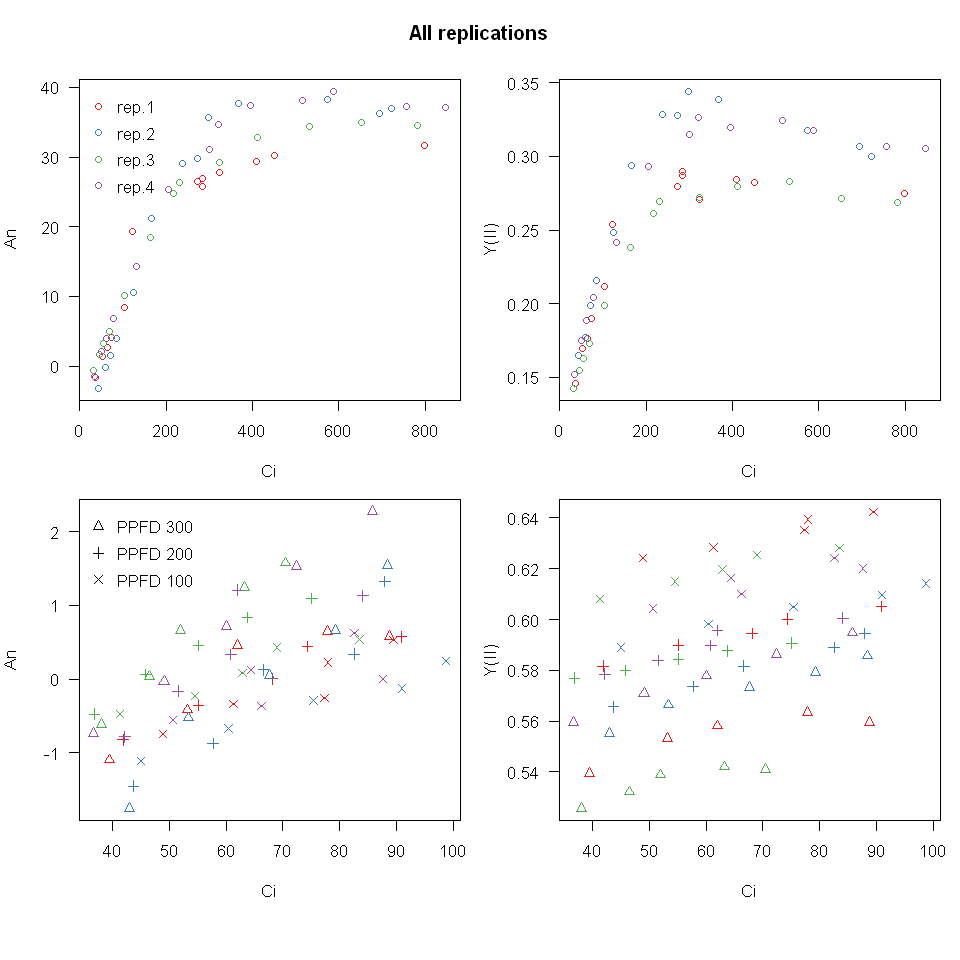

In [4]:
# if there is only one replication, this step is skipped.
if (NumRep!=1) {
## plot all replications together
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,2))
cmap1 <- brewer.pal(NumRep,"Set1")
#A-Ci under saturating light
par(mar=c(4,4,4,1))
tmpxrange <- range(unlist(Obs.Ci)[which(Obs.Q==max(PPFDdetected))]) 
tmpyrange <- range(unlist(Obs.A)[which(Obs.Q==max(PPFDdetected))])
for (looprep2plot in seq(NumRep)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(Obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(Obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(Obs.yii[selrep2plot,]))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    if (looprep2plot==1) {
        plot(tmpCi[tmpidx1], tmpA[tmpidx1], xlab="Ci", ylab="An",pch=1,
             xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
    } else {
        points(tmpCi[tmpidx1], tmpA[tmpidx1], xlab="Ci", ylab="An",pch=1,
               col=cmap1[looprep2plot],las=1)
    }
}
legend("topleft",legend = paste("rep.", seq(NumRep), sep=""), 
       col=c(cmap1), bty="n", pch=1,
       y.intersp=1, yjust=1)
#Y(II)-Ci under saturating light
par(mar=c(4,4,4,1))
tmpxrange <- range(unlist(Obs.Ci)[which(Obs.Q==max(PPFDdetected))]) 
tmpyrange <- range(unlist(Obs.yii)[which(Obs.Q==max(PPFDdetected))])
for (looprep2plot in seq(NumRep)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(Obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(Obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(Obs.yii[selrep2plot,]))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    if (looprep2plot==1) {
        plot(tmpCi[tmpidx1], tmpyii[tmpidx1], xlab="Ci", ylab="Y(II)",pch=1,
             xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
    } else {
        points(tmpCi[tmpidx1], tmpyii[tmpidx1], xlab="Ci", ylab="Y(II)",pch=1,
               col=cmap1[looprep2plot],las=1)
    }
}
#A-Ci under low light
par(mar=c(7,4,1,1))
tmpxrange <- range(unlist(Obs.Ci)[which(Obs.Q!=max(PPFDdetected))])#NA will not be included
tmpyrange <- range(unlist(Obs.A)[which(Obs.Q!=max(PPFDdetected))])
for (looprep2plot in seq(NumRep)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(Obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(Obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(Obs.yii[selrep2plot,]))
    tmpidx2=which(tmpQ!=max(PPFDdetected))
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (looprep2plot==1 && tmploop==1) {
            plot(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                 xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                   col=cmap1[looprep2plot],las=1)
        }
    }
}
legend("topleft",legend = paste("PPFD ", PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))],sep=""), 
       bty="n", pch=seq(2,length(PPFDdetected)),
       y.intersp=1, yjust=1)
#Y(II)-Ci under low light
par(mar=c(7,4,1,1))
tmpxrange <- range(unlist(Obs.Ci)[which(Obs.Q!=max(PPFDdetected))])#NA will not be included
tmpyrange <- range(unlist(Obs.yii)[which(Obs.Q!=max(PPFDdetected))])
for (looprep2plot in seq(NumRep)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(Obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(Obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(Obs.yii[selrep2plot,]))
    tmpidx2=which(tmpQ!=max(PPFDdetected))
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (looprep2plot==1 && tmploop==1) {
            plot(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                 xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                   col=cmap1[looprep2plot],las=1)
        }
    }
}
title("All replications", outer=TRUE, line=-2)
## save plot
tmpdisp <- dev.copy(pdf, file.path(BayesOPTFolder,OPTFolderName,"allreps","s1.2-raw curves-allreps.pdf"))
tmpdisp <- dev.off()
}

### 1.2.2 Plot each replication

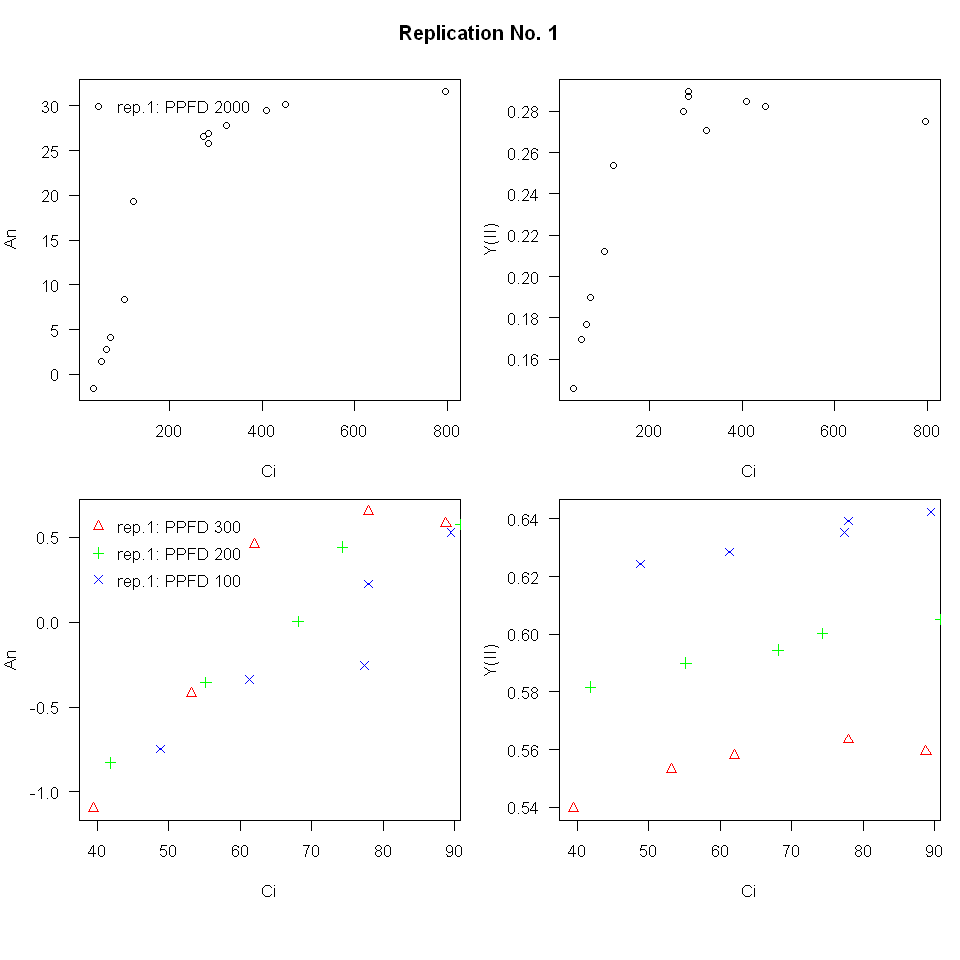

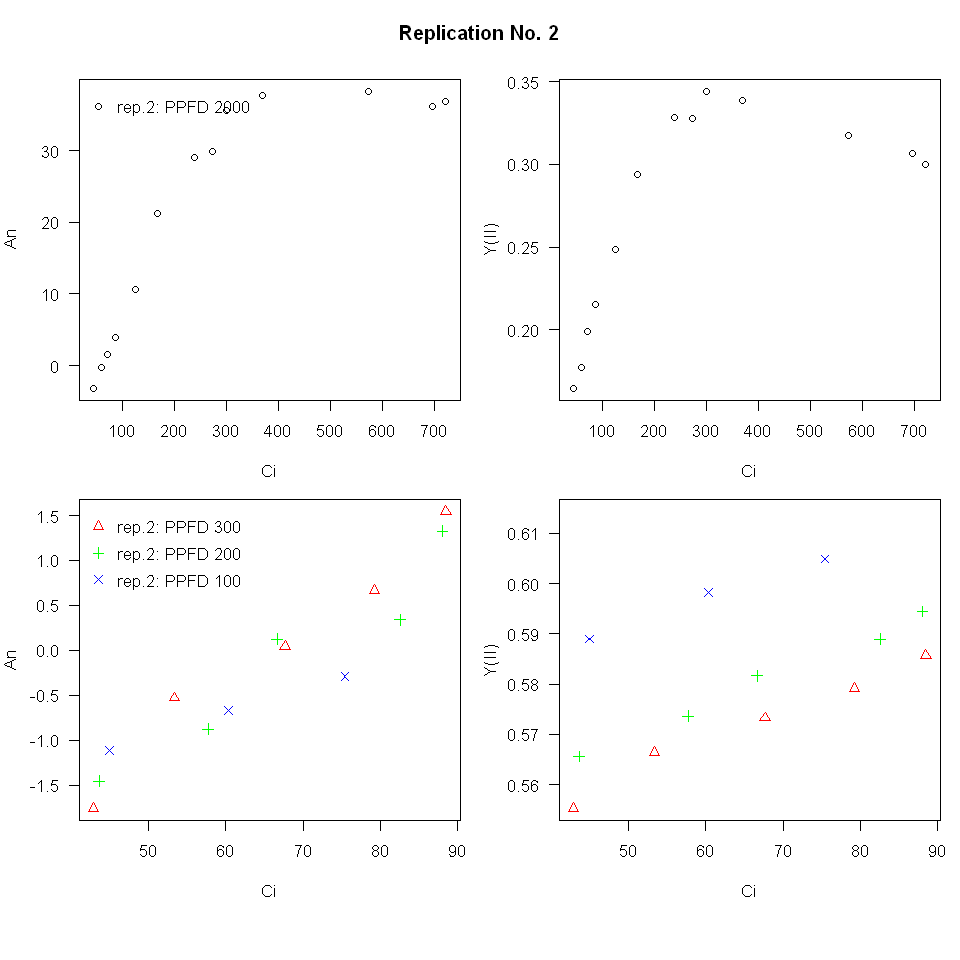

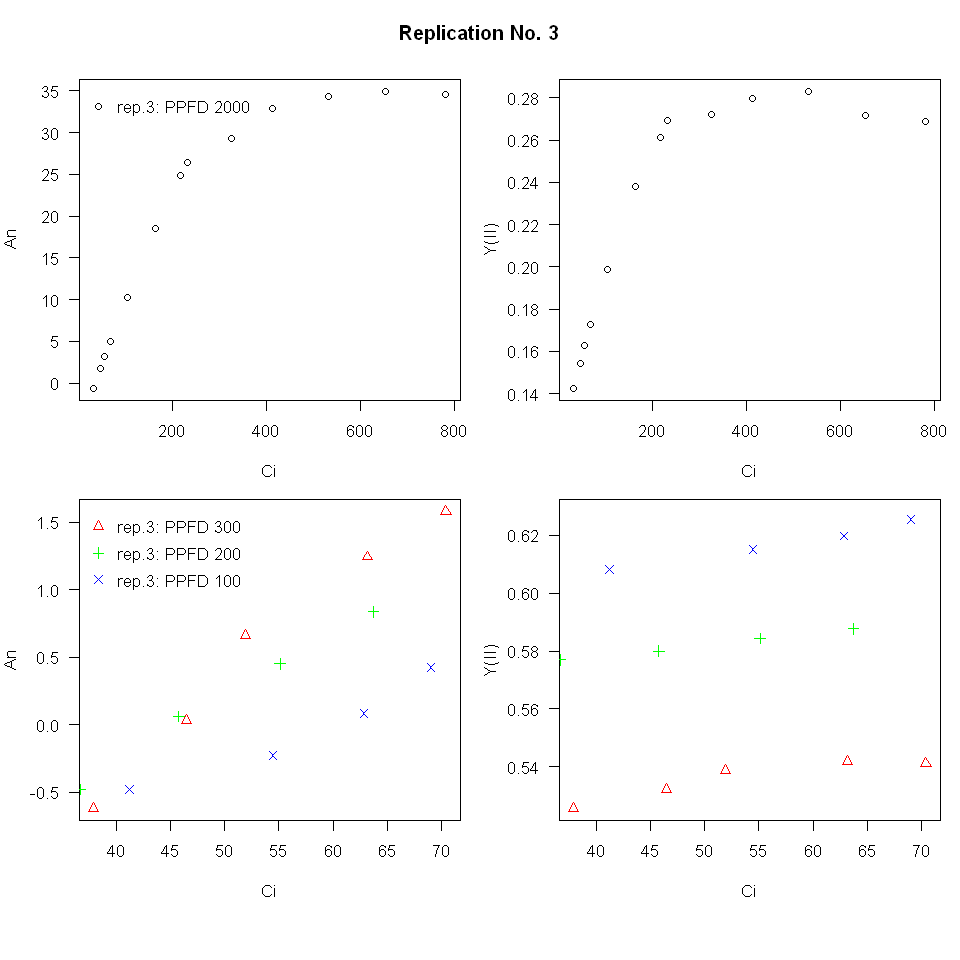

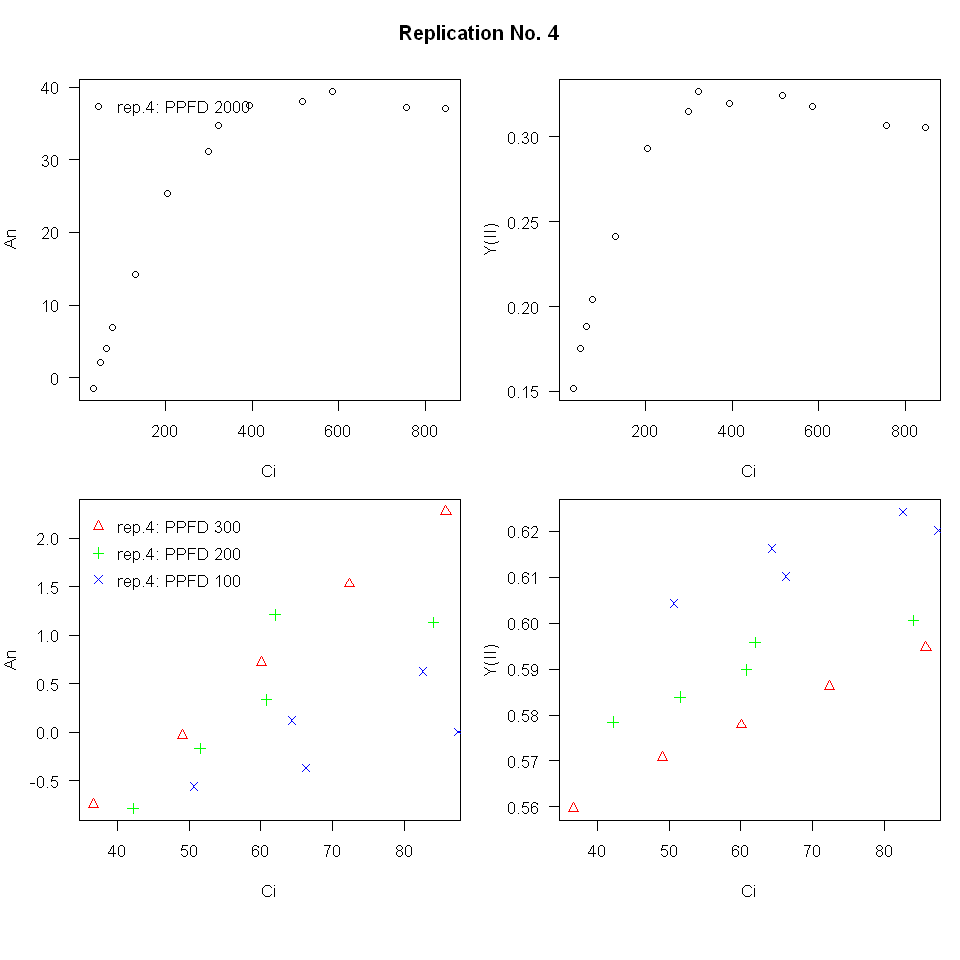

In [5]:
## plot each replication
for (looprep2plot in seq(NumRep)) {
    selrep2plot=looprep2plot
    options(repr.plot.width = 8, repr.plot.height = 8)
    par(mfrow=c(2,2))
    tmpCi=na.omit(unlist(Obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(Obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(Obs.yii[selrep2plot,]))
    # identify data under saturating irradiance and plot
    par(mar=c(4,4,4,1))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    plot(tmpCi[tmpidx1],tmpA[tmpidx1],xlab="Ci",ylab="An",las=1)
    legend('topleft', legend = paste("rep.", selrep2plot, ": PPFD ",max(PPFDdetected), sep=""), 
           col="black", bty="n", box.lty=0, pch=1, yjust=1)
    par(mar=c(4,4,4,1))
    plot(tmpCi[tmpidx1],tmpyii[tmpidx1],xlab="Ci",ylab="Y(II)",las=1)
    # identify data under low light and plot
    par(mar=c(7,4,1,1))
    idxlowlights=which(tmpQ!=max(PPFDdetected))
    cmap2 <- rainbow(length(PPFDdetected)-1)
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (tmploop==1) {
            plot(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                 ylim=range(tmpA[idxlowlights]), col=cmap2[tmploop],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                   col=cmap2[tmploop],las=1)
        }
    }
    legend("topleft",legend = paste("rep.", selrep2plot, ": PPFD ",PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))], sep=""), 
           col=c(cmap2), bty="n", box.lty=0, pch=seq(length(PPFDdetected)-1)+1,
           y.intersp=1, yjust=1)
    par(mar=c(7,4,1,1))
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (tmploop==1) {
            plot(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                 ylim=range(tmpyii[idxlowlights]), col=cmap2[tmploop],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                   col=cmap2[tmploop],las=1)
        }
    }
    title(paste("Replication No.",looprep2plot), outer=TRUE, line=-2)
    
    ## save plot
    tmpfilename <- paste("s1.2-raw curves-rep",looprep2plot,".pdf", sep="")
    tmpstr=paste("rep", looprep2plot, sep="")
    tmpdisp <- dev.copy(pdf, file.path(BayesOPTFolder,OPTFolderName,tmpstr,tmpfilename))
    tmpdisp <- dev.off()
}

# Step 2. Configure Bayesian estimation and run

## 2.1 Configure prefixed parameters

In [6]:
##############################
#  USER CONFIGURATION [2/3]  #
##############################

# Prefixed Km during Bayesian estimation #
fixedpar <- list(Km=428)
# fixedpar <- list(Km=535.3270) # this is true value of Km for synthetic data "./data/syntheticdata0827.csv"

# Typical Km values for several species at 210 mbar O2 (von Caemmerer 2000)
# Oryza Sativa: 428 ubar
# Nicotiana tabacum: 468 ubar
# Spinach: 712 ubar

## 2.2 Configure JAGS

In [7]:
##############################
#  USER CONFIGURATION [3/3]  #
##############################
JAGS.ini <- list(CFG.nchain=3, CFG.nburnin=10000, CFG.niter=20000, CFG.nthin=1)
# CFG.nchain: number of Markov chains for JAGS
# CFG.nburnin: length of burn in, i.e. number of iterations to discard at the beginning of MCMC.
# CFG.niter: number of total iterations per chain including burn in.
# CFG.nthin: thinning rate of recorded sampling of a Markov chain.
# these parameters are passed to R function jags.parallel in R package R2jags.

## 2.3 Run JAGS
Bayesian estimation with data of all replications and each replication.

In [8]:
# run JAGS with each replication as observation of Bayesian parameter estimation
SaveJAGSOneRep <- list()
for (looprep4jags in seq(NumRep)) {
    timestart <- Sys.time()
    tmpCi=na.omit(unlist(Obs.Ci[looprep4jags,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[looprep4jags,]))
    tmpA=na.omit(unlist(Obs.A[looprep4jags,]))
    tmpyii=na.omit(unlist(Obs.yii[looprep4jags,]))
    tmpjagsfit.p <- FunJAGSFvCBgm(tmpCi, tmpQ, tmpA, tmpyii, PPFDdetected, fixedpar, JAGS.ini)
    timeend <- Sys.time()
    runningtime <- timeend - timestart
    cat(paste("JAGS with replication No.", looprep4jags, " done: ", runningtime, " secs\n"), sep="")
    SaveJAGSOneRep[[looprep4jags]] <- tmpjagsfit.p
}
# run JAGS with all replications as observation of Bayesian parameter estimation
if (NumRep!=1) {
    timestart <- Sys.time()
    tmpCi=na.omit(unlist(Obs.Ci))#compatible to replications with different total number of measured points
    tmpQ=na.omit(unlist(Obs.Q))
    tmpA=na.omit(unlist(Obs.A))
    tmpyii=na.omit(unlist(Obs.yii))
    SaveJAGSAllReps <- FunJAGSFvCBgm(tmpCi, tmpQ, tmpA, tmpyii, PPFDdetected, fixedpar, JAGS.ini)
    timeend <- Sys.time()
    runningtime <- timeend - timestart
    cat(paste("JAGS with all replications done: ", runningtime, " secs\n"), sep="")
}

JAGS with replication No. 1  done:  9.21130895614624  secs
JAGS with replication No. 2  done:  8.89574098587036  secs
JAGS with replication No. 3  done:  9.17832612991333  secs
JAGS with replication No. 4  done:  9.21464681625366  secs
JAGS with all replications done:  36.5611619949341  secs


## 2.4 Check convergence

In [9]:
# Print summary of JAGS results
# mean value, standard deviation and different quantiles are shown
# Any Rhat>1.1 means Bayesian estimation is not converged yet
tmp_filename=file.path(BayesOPTFolder,OPTFolderName,"s2.4-summary JAGS results.csv")
if (NumRep!=1) {
    cat("***********************************************\n")
    cat(paste("Summary of JAGS with all replications\n"))
    cat("***********************************************\n")
    print(SaveJAGSAllReps)
    cat("\n\n\n\n")
    
    # write summary to csv file
    write.table("Summary of JAGS with all replications", file=tmp_filename, row.names=FALSE, col.names=FALSE)
    tmptable=SaveJAGSAllReps$BUGSoutput$summary[1:10,]
    write.table(tmptable, file=tmp_filename, sep=",", col.names=NA, append=TRUE)
    cat("\n", file=tmp_filename, append=TRUE)
}
for (looprep4jags in seq(NumRep)) {
    cat("***********************************************\n")
    cat(paste("Summary of JAGS with replication No.", looprep4jags, "\n"))
    cat("***********************************************\n")
    print(SaveJAGSOneRep[[looprep4jags]])
    cat("\n\n\n\n")
    
    # write summary to csv file
    tmpstr=paste("Summary of JAGS with replication No.", looprep4jags, sep="")
    if (NumRep==1) {
        write.table(tmpstr, file=tmp_filename, row.names=FALSE, col.names=FALSE)
    } else {
        write.table(tmpstr, file=tmp_filename, row.names=FALSE, col.names=FALSE, append=TRUE)
    }
    tmptable=SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$summary[1:10,]
    write.table(tmptable, file=tmp_filename, sep=",", col.names=NA, append=TRUE)
    cat("\n", file=tmp_filename, append=TRUE)
}

***********************************************
Summary of JAGS with all replications
***********************************************
Inference for Bugs model at "./src/fvcb_ayii_ciLL_gm_fixKm_vR.txt", fit using jags,
 3 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 30000 iterations saved
        mu.vect sd.vect     2.5%      25%      50%      75%    97.5%  Rhat
Gstar    35.449   2.656   29.794   33.758   35.641   37.285   40.199 1.003
J[1]    179.628   2.739  174.136  177.842  179.621  181.464  185.039 1.002
J[2]     50.372   1.041   48.274   49.704   50.371   51.062   52.400 1.003
J[3]     35.221   0.722   33.760   34.752   35.221   35.695   36.632 1.003
J[4]     18.531   0.380   17.761   18.284   18.533   18.782   19.274 1.003
Km      428.000   0.000  428.000  428.000  428.000  428.000  428.000 1.000
Resp      1.658   0.385    0.945    1.395    1.641    1.904    2.466 1.002
Vcmax   100.989   4.935   94.005   97.559  100.050  103.432  113.087 1.003
rm        0.

Warning message in write.table(tmptable, file = tmp_filename, sep = ",", col.names = NA, :
"appending column names to file"


***********************************************
Summary of JAGS with replication No. 1 
***********************************************
Inference for Bugs model at "./src/fvcb_ayii_ciLL_gm_fixKm_vR.txt", fit using jags,
 3 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 30000 iterations saved
         mu.vect  sd.vect     2.5%       25%       50%       75%     97.5%
Gstar     28.458    3.562   20.929    26.244    28.567    30.833    35.152
J[1]     157.392    4.212  148.679   154.726   157.458   160.155   165.642
J[2]      46.604    1.415   43.741    45.703    46.604    47.519    49.455
J[3]      33.295    1.004   31.256    32.656    33.299    33.950    35.294
J[4]      17.759    0.536   16.684    17.412    17.764    18.103    18.826
Km       428.000    0.000  428.000   428.000   428.000   428.000   428.000
Resp       2.622    0.613    1.483     2.208     2.598     3.004     3.913
Vcmax    106.093    7.307   95.110   101.237   104.985   109.453   124.697
rm        

Warning message in write.table(tmptable, file = tmp_filename, sep = ",", col.names = NA, :
"appending column names to file"


***********************************************
Summary of JAGS with replication No. 2 
***********************************************
Inference for Bugs model at "./src/fvcb_ayii_ciLL_gm_fixKm_vR.txt", fit using jags,
 3 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 30000 iterations saved
        mu.vect  sd.vect     2.5%      25%      50%      75%     97.5%  Rhat
Gstar    35.639    5.133   23.903   32.624   36.002   39.009    44.890 1.003
J[1]    196.495    6.712  183.500  191.968  196.506  200.961   209.717 1.004
J[2]     52.143    2.160   48.131   50.664   52.088   53.566    56.489 1.004
J[3]     35.305    1.466   32.595   34.305   35.271   36.292    38.245 1.004
J[4]     18.332    0.756   16.917   17.819   18.313   18.834    19.833 1.004
Km      428.000    0.000  428.000  428.000  428.000  428.000   428.000 1.000
Resp      2.707    0.813    1.240    2.169    2.664    3.182     4.476 1.002
Vcmax   109.629    9.619   98.121  103.937  107.600  112.383   137.27

Warning message in write.table(tmptable, file = tmp_filename, sep = ",", col.names = NA, :
"appending column names to file"


***********************************************
Summary of JAGS with replication No. 3 
***********************************************
Inference for Bugs model at "./src/fvcb_ayii_ciLL_gm_fixKm_vR.txt", fit using jags,
 3 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 30000 iterations saved
         mu.vect  sd.vect      2.5%       25%       50%       75%     97.5%
Gstar     31.936    2.230    27.504    30.476    31.962    33.415    36.297
J[1]     168.863    1.552   165.893   167.832   168.831   169.861   172.051
J[2]      49.532    0.777    48.002    49.023    49.528    50.040    51.069
J[3]      35.997    0.560    34.900    35.633    35.994    36.367    37.110
J[4]      19.091    0.293    18.520    18.898    19.087    19.283    19.671
Km       428.000    0.000   428.000   428.000   428.000   428.000   428.000
Resp       1.261    0.288     0.718     1.068     1.253     1.444     1.852
Vcmax    102.011    5.640    92.662    97.943   101.520   105.393   114.476
r

Warning message in write.table(tmptable, file = tmp_filename, sep = ",", col.names = NA, :
"appending column names to file"


***********************************************
Summary of JAGS with replication No. 4 
***********************************************
Inference for Bugs model at "./src/fvcb_ayii_ciLL_gm_fixKm_vR.txt", fit using jags,
 3 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 30000 iterations saved
         mu.vect  sd.vect     2.5%      25%       50%       75%     97.5%  Rhat
Gstar     31.154    3.758   23.168   28.699    31.415    33.819    37.842 1.002
J[1]     187.667    3.276  181.588  185.443   187.566   189.768   194.441 1.019
J[2]      51.331    1.175   49.148   50.513    51.297    52.081    53.828 1.025
J[3]      34.931    0.797   33.452   34.381    34.914    35.443    36.606 1.025
J[4]      18.218    0.412   17.450   17.931    18.207    18.481    19.086 1.025
Km       428.000    0.000  428.000  428.000   428.000   428.000   428.000 1.000
Resp       1.774    0.555    0.767    1.395     1.736     2.120     2.963 1.002
Vcmax    110.495    9.634   97.650  103.377  

Warning message in write.table(tmptable, file = tmp_filename, sep = ",", col.names = NA, :
"appending column names to file"


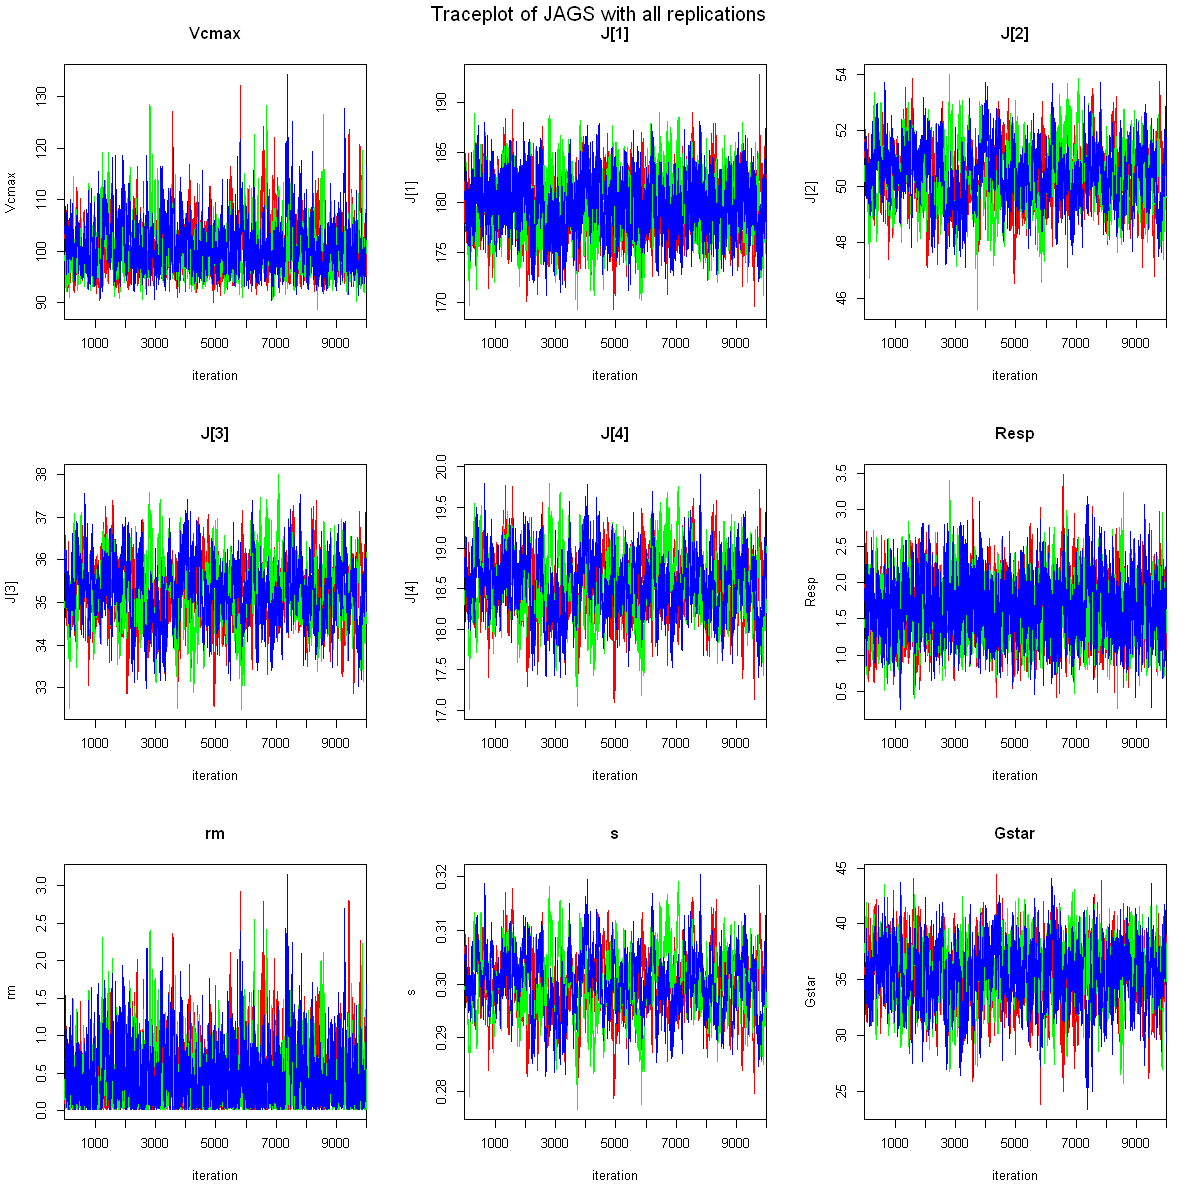

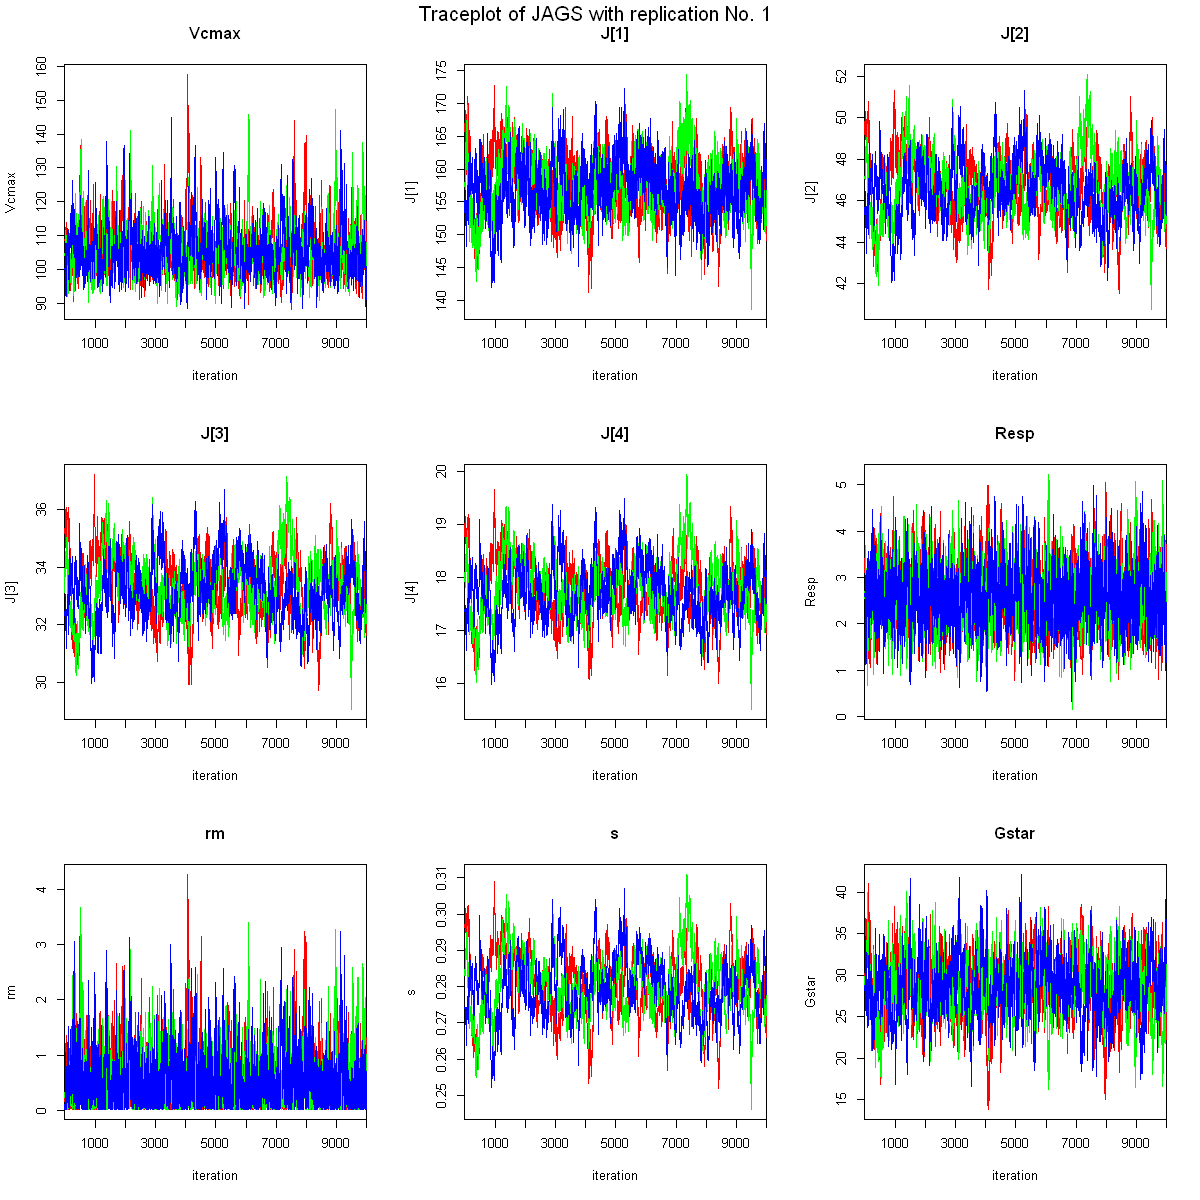

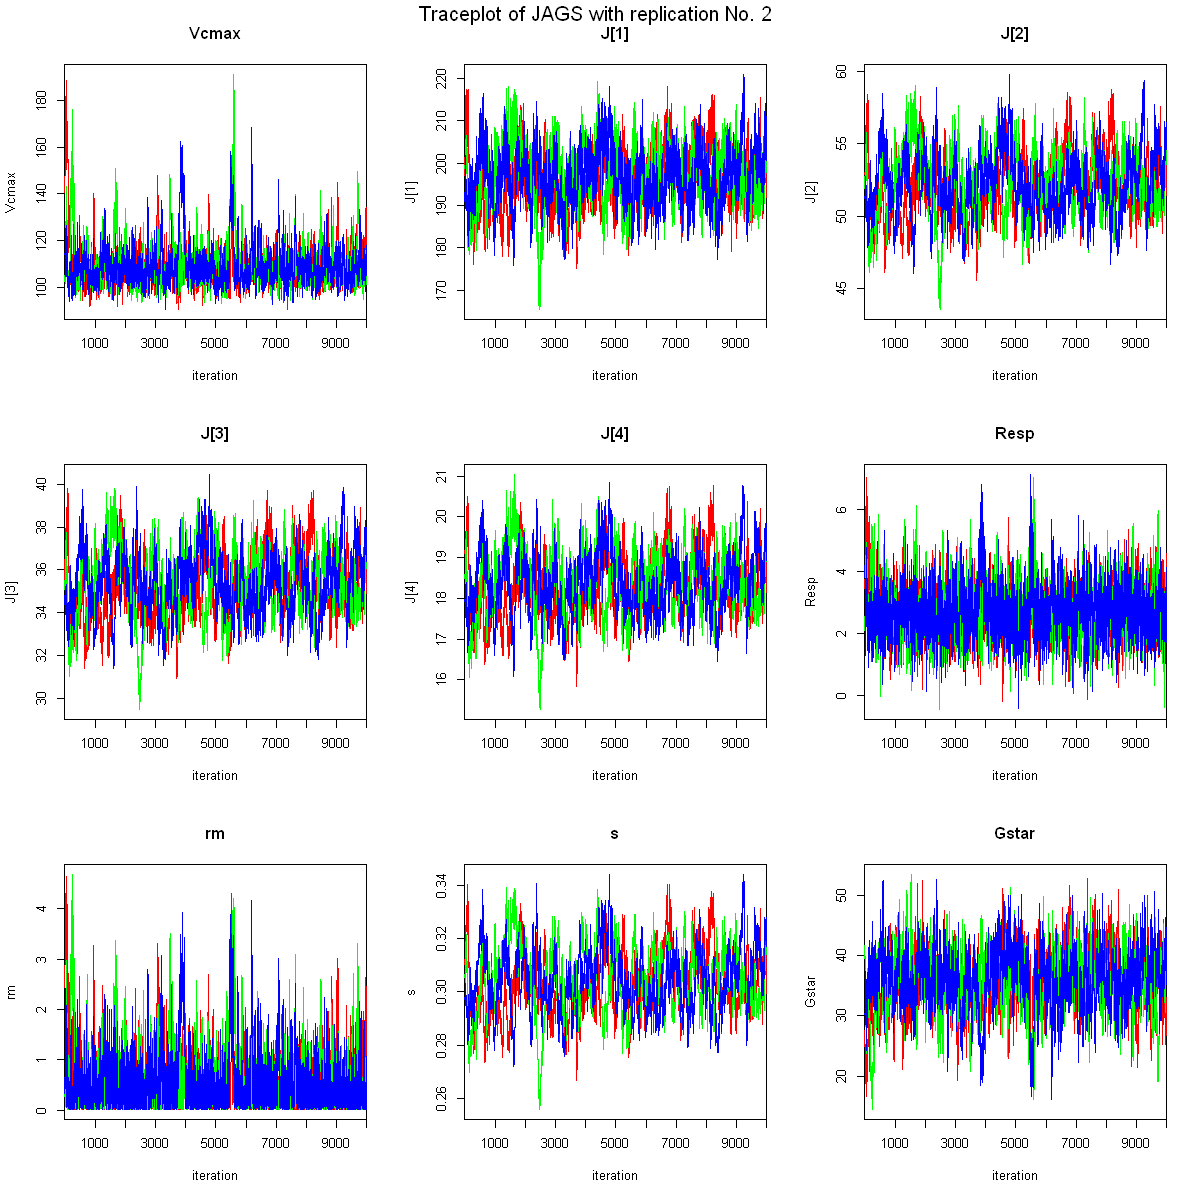

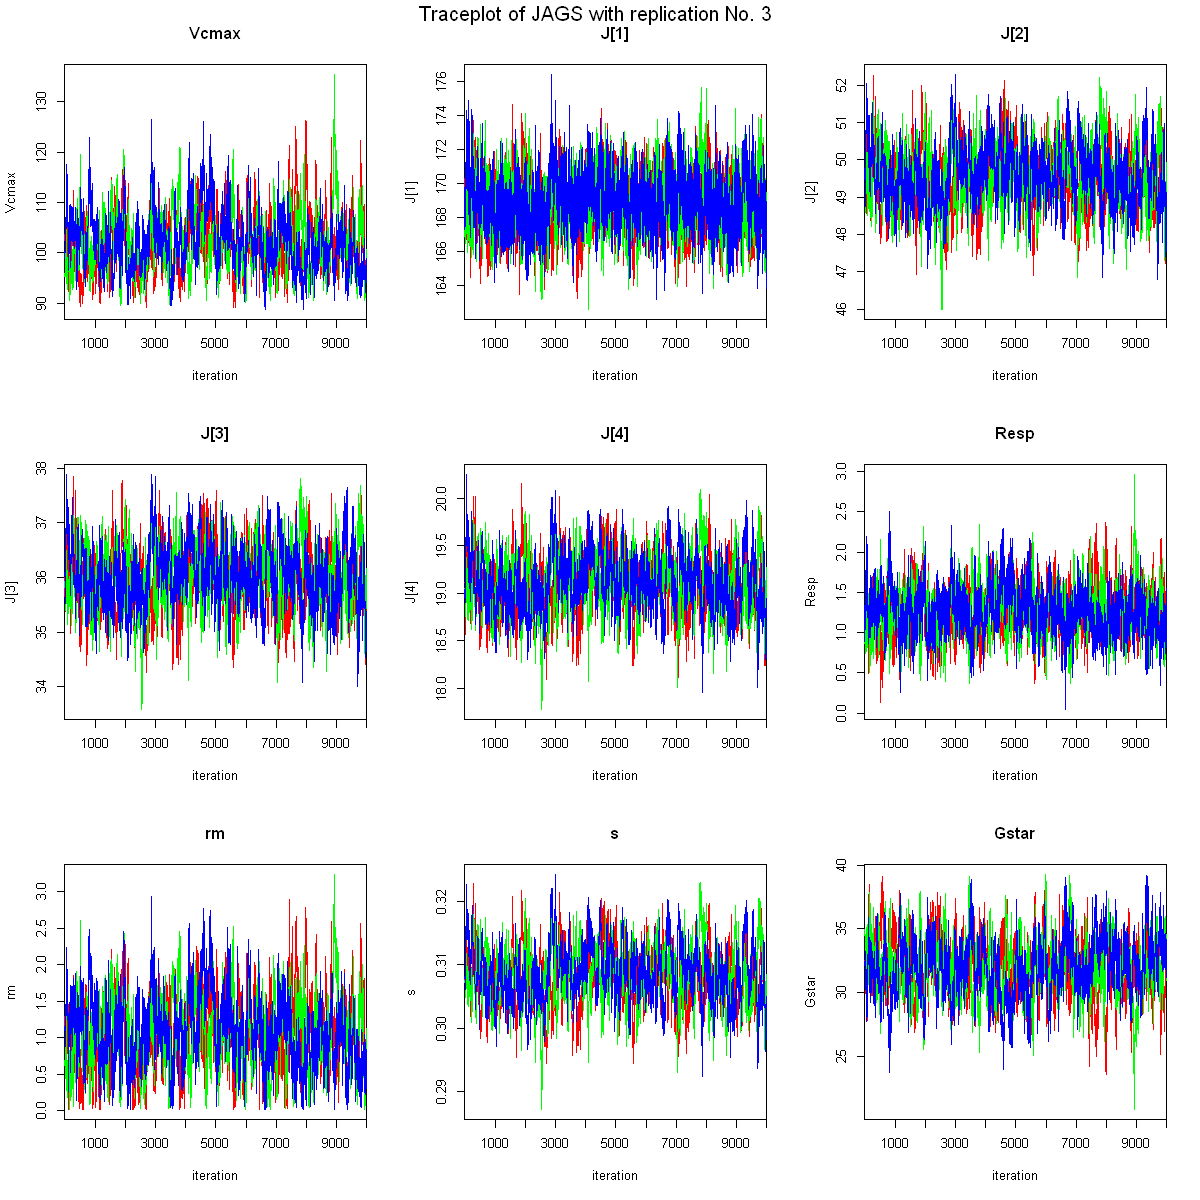

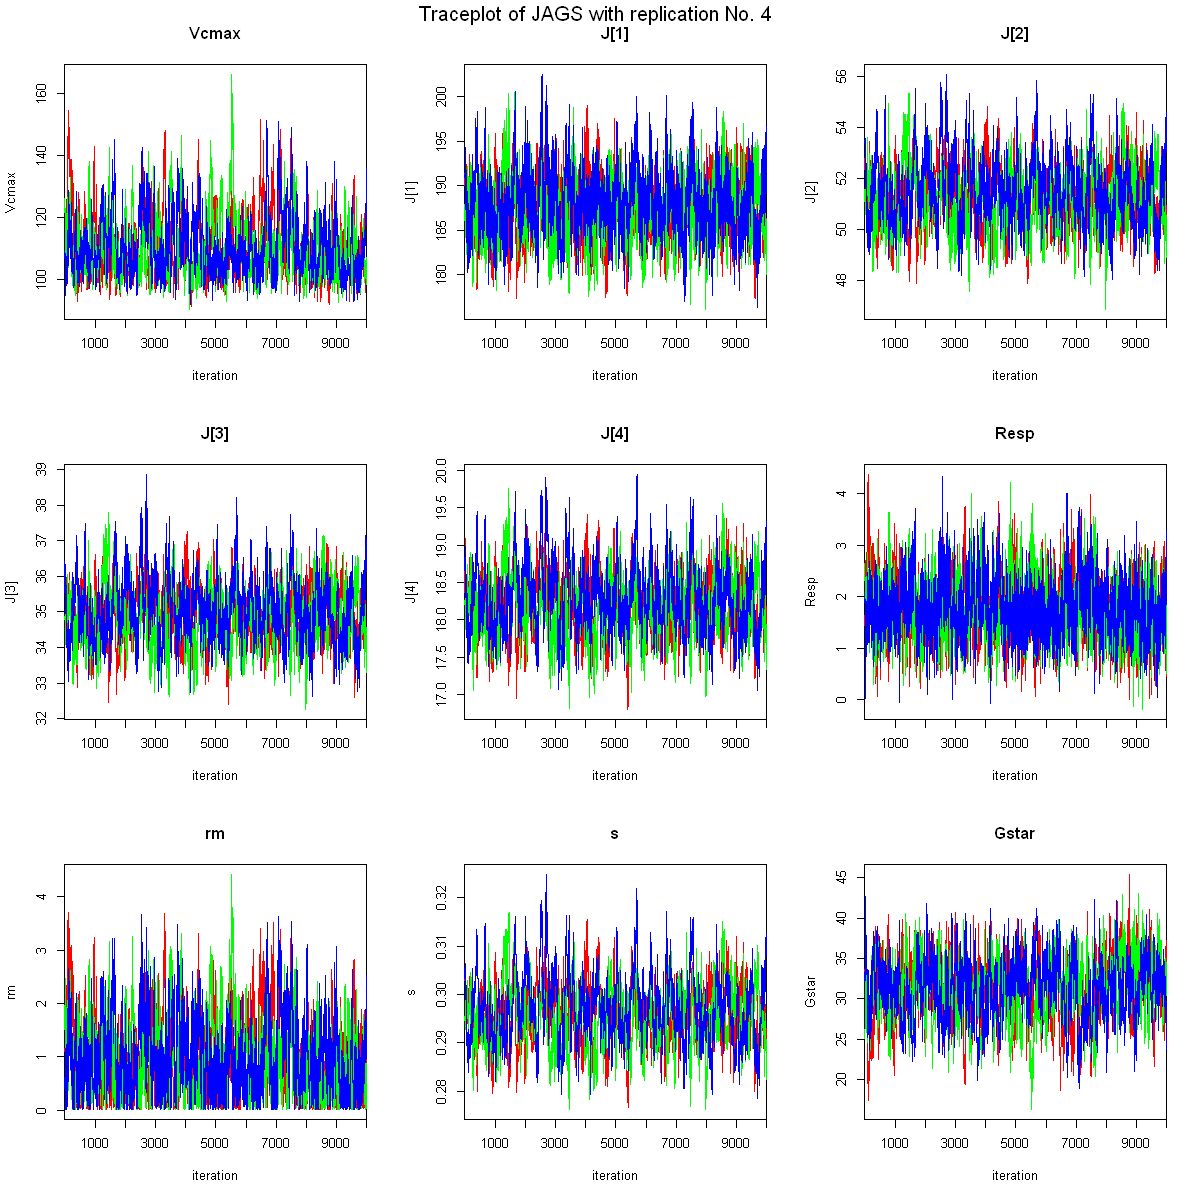

In [10]:
# plot the Monte-Carlo-Markov-Chain of approximated posterior distributions
if (NumRep!=1) {
    #plot.new()
    options(repr.plot.width=10, repr.plot.height=10)
    traceplot(SaveJAGSAllReps, mfrow=c(3,3), varname = c('Vcmax','J','Resp','rm','s','Gstar'))
    mtext(paste("Traceplot of JAGS with all replications\n"), side = 3, line = -3, outer=TRUE)
    ## save plot
    tmpdisp <- dev.copy(pdf, file.path(BayesOPTFolder,OPTFolderName,"allreps","s2.4-traceplot-allrep.pdf"))
    tmpdisp <- dev.off()
}
for (looprep4jags in seq(NumRep)) {
    #plot.new()
    options(repr.plot.width=10, repr.plot.height=10)
    traceplot(SaveJAGSOneRep[[looprep4jags]], mfrow=c(3,3), varname = c('Vcmax','J','Resp','rm','s','Gstar'))
    mtext(paste("Traceplot of JAGS with replication No.", looprep4jags, "\n"), side = 3, line = -3, outer=TRUE)
    ## save plot
    tmpfilename <- paste("s2.4-traceplot-rep",looprep4jags,".pdf", sep="")
    tmpstr=paste("rep", looprep4jags, sep="")
    tmpdisp <- dev.copy(pdf, file.path(BayesOPTFolder,OPTFolderName,tmpstr,tmpfilename))
    tmpdisp <- dev.off()
}

# Step 3. Plot posterior distribution and save results

## 3.1 Plot marginal posterior distribution of each estimated parameter

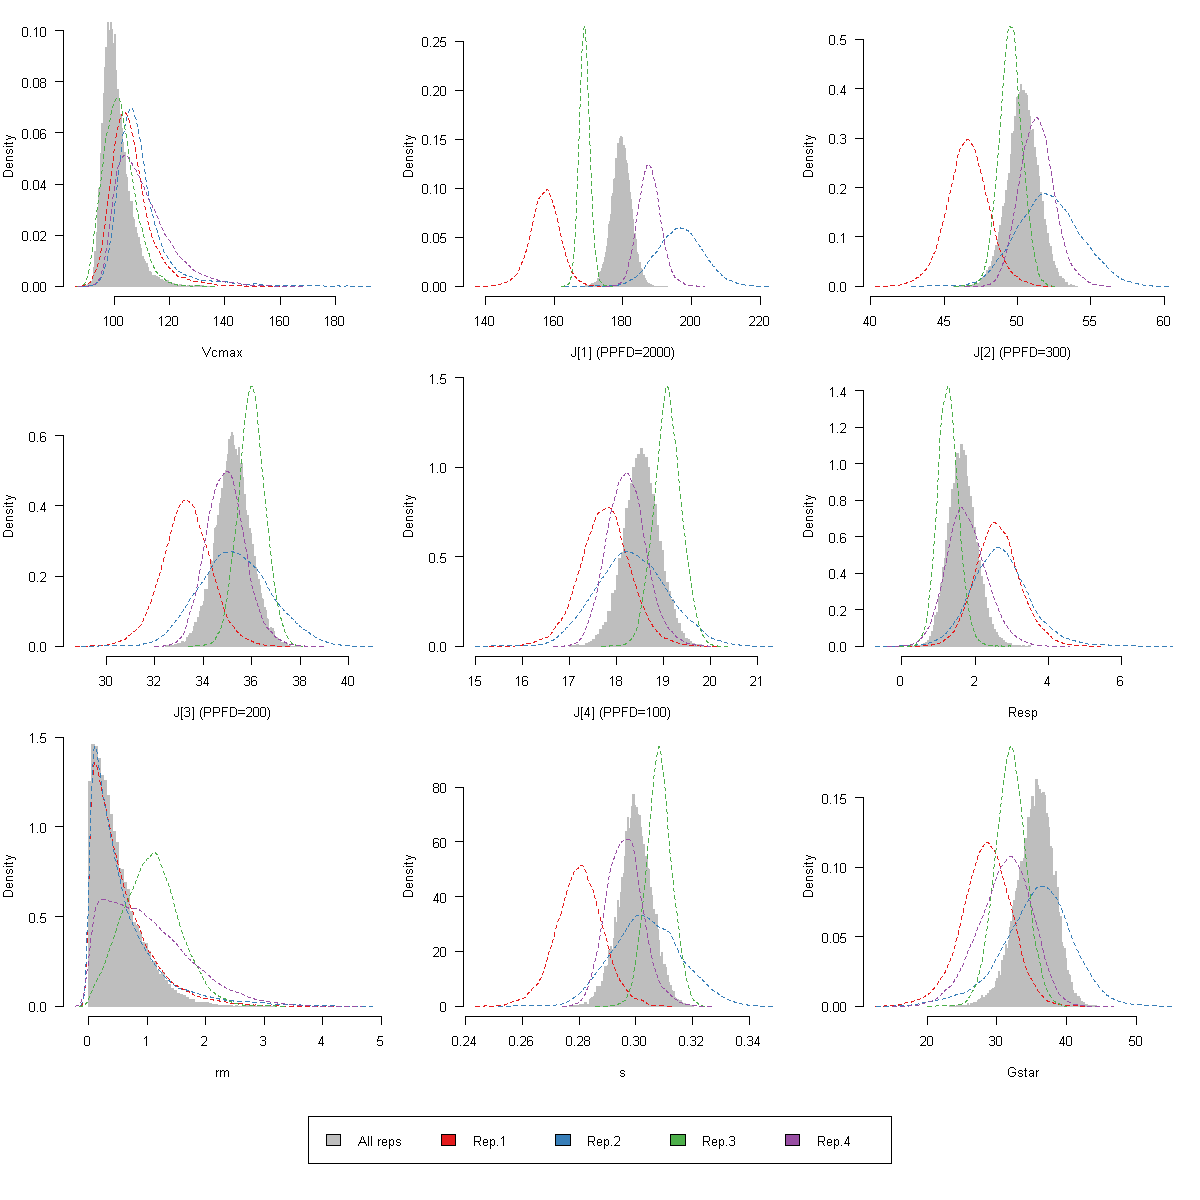

In [11]:
#jagsfit.mcmc <- as.mcmc(jagsfit.p)
#densityplot(jagsfit.mcmc) #xyplot(jagsfit.mcmc) # same as traceplot
cmap3=brewer.pal(NumRep,"Set1")
#par(mfrow=c(3,3))
#options(repr.plot.width=10, repr.plot.height=10)
layout(matrix(c(seq(9),rep(10,3)),4,3,byrow = TRUE), rep(3,3), c(rep(3,3),1))

varname2plot <- c('Vcmax','J','Resp','rm','s','Gstar')
for (tmpvar in varname2plot) {
    if (tmpvar != 'J') {
        tmpidx <- which(tmpvar == names(SaveJAGSAllReps$BUGSoutput$sims.list))
        #detect tmpxrange and tmpyrange for plot
        tmpxrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]))$x)
        tmpyrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]))$y)
        for (looprep4jags in seq(NumRep)) {
            tmpxrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]]))$x)
            tmpyrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]]))$y)
            #update range
            tmpxrange <- range(c(tmpxrange,tmpxrange2))
            tmpyrange <- range(c(tmpyrange,tmpyrange2))
        }
        #density plot
        par(mar=c(4,4,1,1))
        hist(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]),
             xlim=tmpxrange, ylim=tmpyrange, col="gray", border="gray",
             breaks=100, main=NULL, xlab=tmpvar, las=1, prob=TRUE)
        for (looprep4jags in seq(NumRep)){
            lines(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]])),
                   col=cmap3[looprep4jags], lty=2, main="",xlab=tmpvar,las=1)
        }
        
    }
    else {
        tmpidx <- which(tmpvar == names(SaveJAGSAllReps$BUGSoutput$sims.list))
        for (looplightlevel in seq(ncol(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]))) {
            #detect tmpxrange and tmpyrange for plot
            tmpxrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$x)
            tmpyrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$y)
            for (looprep4jags in seq(NumRep)) {
                tmpxrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$x)
                tmpyrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$y)
                #update range
                tmpxrange <- range(c(tmpxrange,tmpxrange2))
                tmpyrange <- range(c(tmpyrange,tmpyrange2))
            }
            #density plot
            par(mar=c(4,4,1,1))
            hist(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]),
                 xlim=tmpxrange, ylim=tmpyrange, col="gray", border="gray", breaks=100, main=NULL, 
                 xlab=paste(tmpvar,"[",looplightlevel,"] (PPFD=",PPFDdetected[looplightlevel],")", sep=""), las=1, prob=TRUE)
            for (looprep4jags in seq(NumRep)) {
                lines(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]][,looplightlevel])),
                      col=cmap3[looprep4jags], lty=2, main="",xlab=tmpvar,las=1)
            }
        }
    }
}
par(mar=c(0,0,0,0))
plot.new()
legend(x="center", ncol=NumRep+1,legend=c("All reps",paste("Rep.",seq(NumRep),sep="")),
       fill=c("gray",cmap3))

## save plot
tmpdisp <- dev.copy(pdf, file.path(BayesOPTFolder,OPTFolderName,"s3.1-marginal posterior.pdf"))
tmpdisp <- dev.off()

## 3.2 Plot bivariate posterior distribution

In [12]:
# to dev: let user select which parameters to plot the bivariate distribution

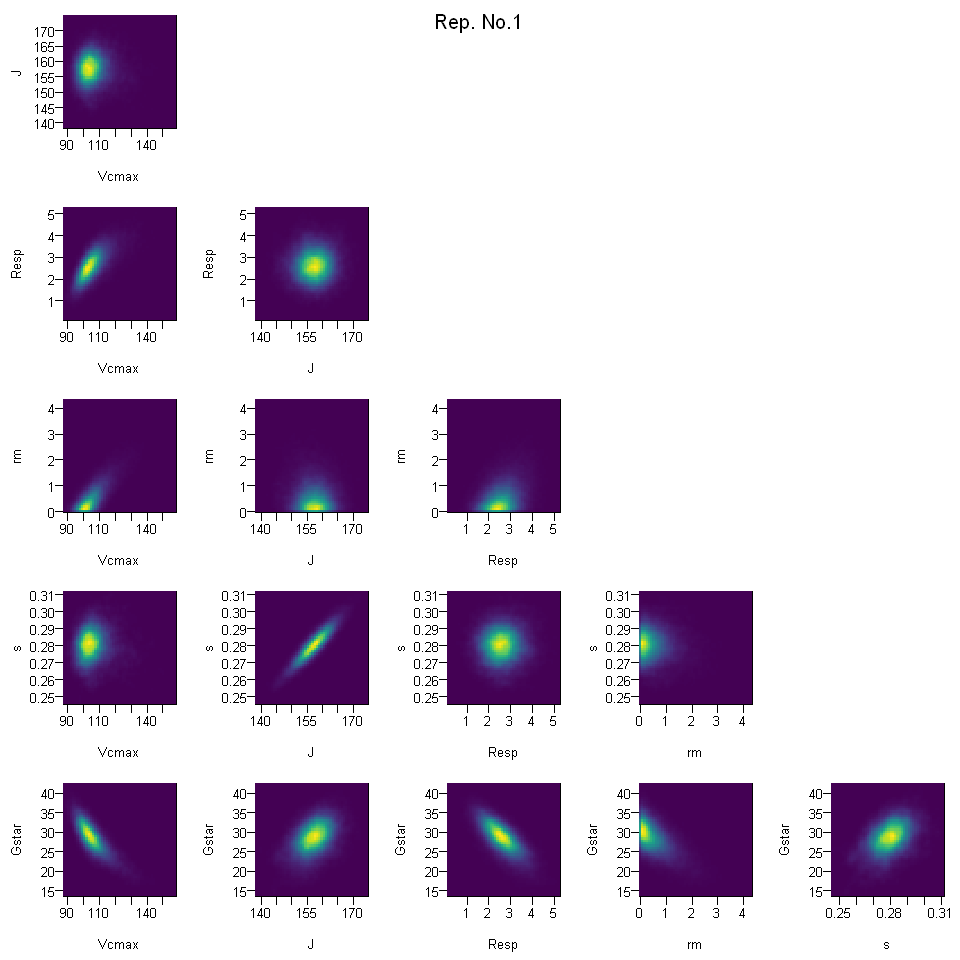

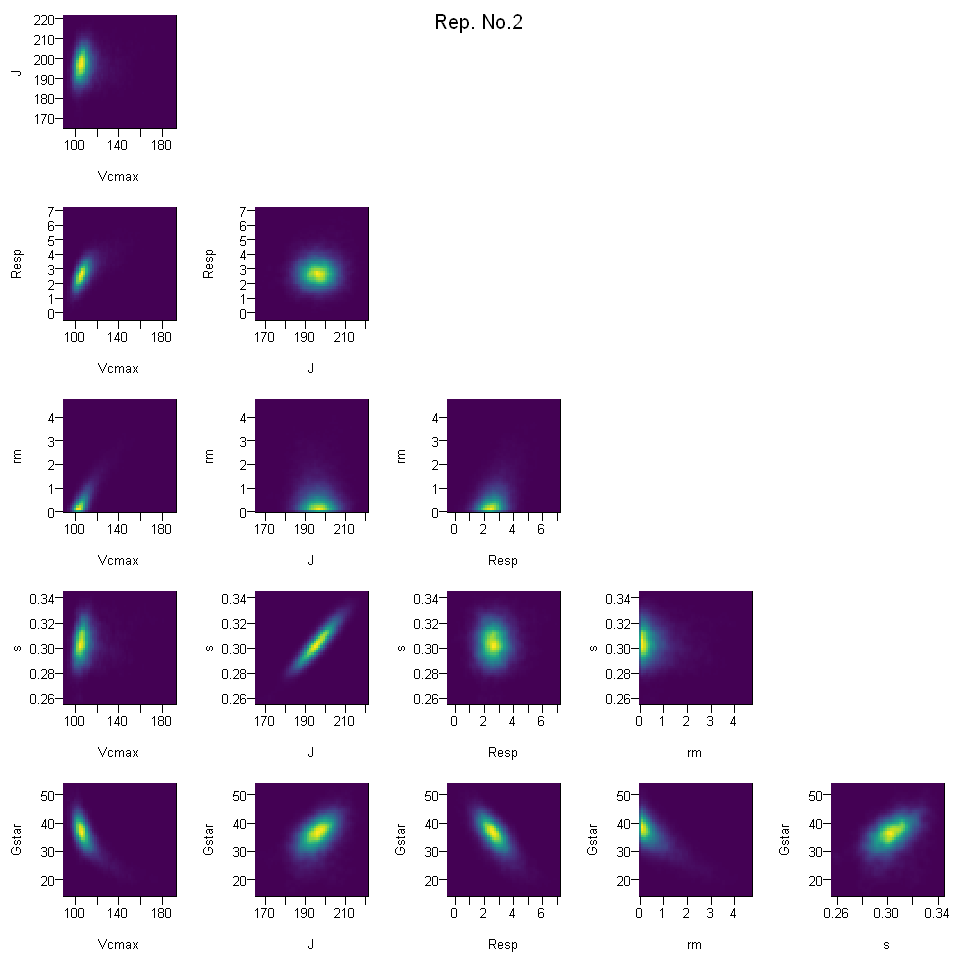

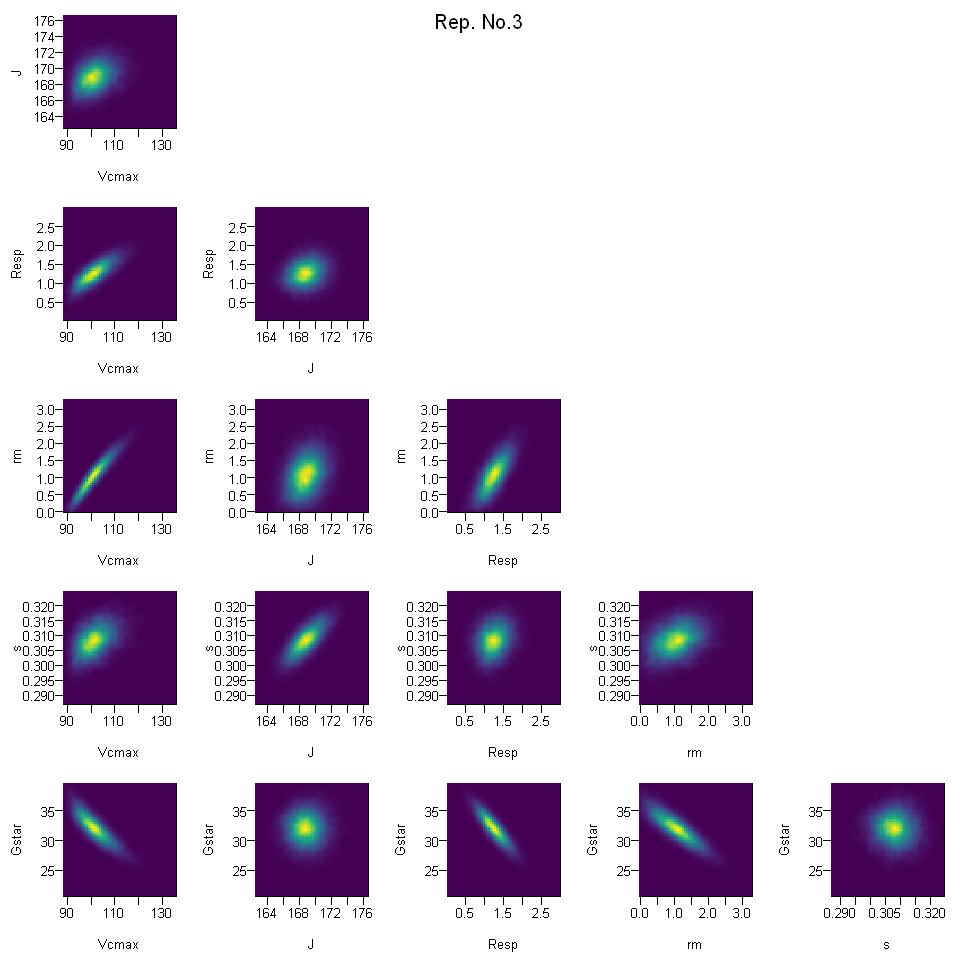

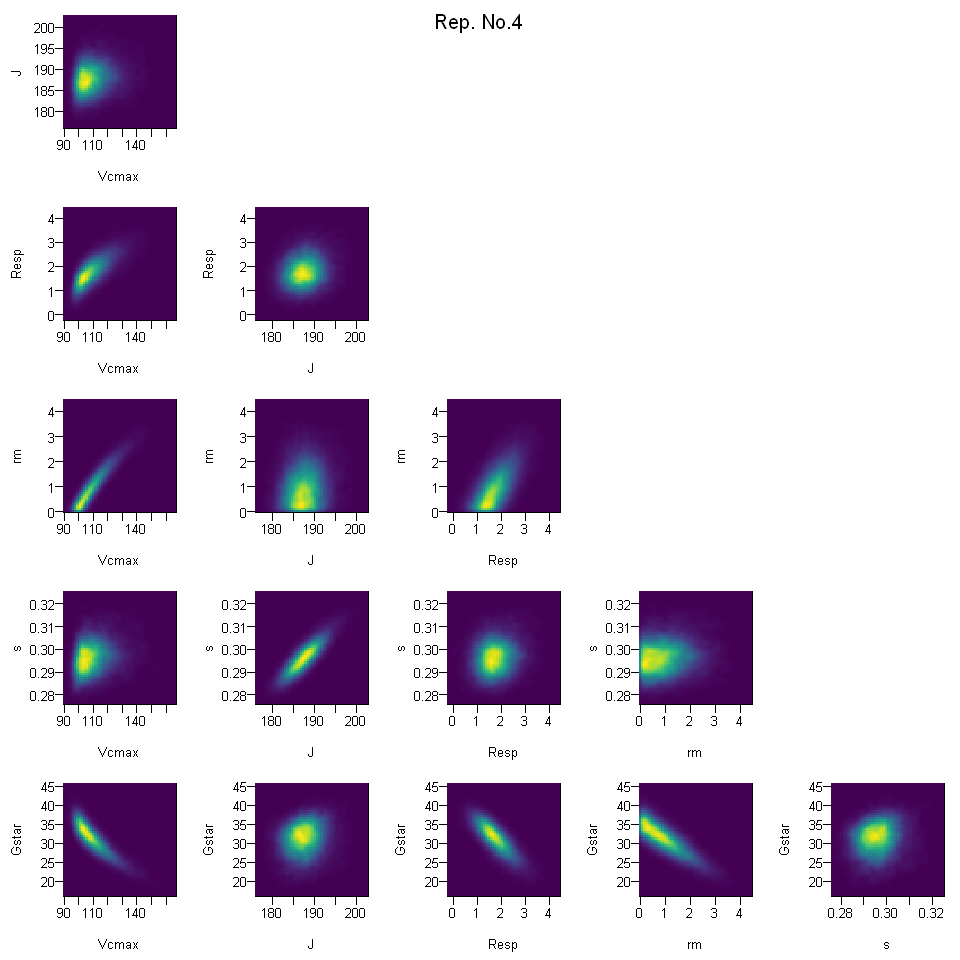

In [13]:
for (looprep2plot in seq(NumRep)) {
    plot.new()
    varname2plot <- c('Vcmax','J','Resp','rm','s','Gstar')
    par(mfrow=c(length(varname2plot)-1,length(varname2plot)-1))
    options(repr.plot.width=8, repr.plot.height=8)
    for (tmpint1 in seq(length(varname2plot)-1)) {
        tmpvar1=varname2plot[tmpint1]
        tmpidx1 <- which(tmpvar1 == names(SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list))
        for (tmpint2 in seq(tmpint1+1,length(varname2plot))) {
            tmpvar2=varname2plot[tmpint2]
            tmpidx2 <- which(tmpvar2 == names(SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list))
            if (tmpvar1 != 'J') {
                xdata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx1]]
            }
            else {
                xdata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx1]][,which.max(PPFDdetected)]
            }
            if (tmpvar2 != 'J') {
                ydata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx2]]
            }
            else {
                ydata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx2]][,which.max(PPFDdetected)]
            }
            tmp.kde <- kde2d(xdata, ydata, n=50)
            #par(mfg=c(tmpint1, tmpint2-1))
            #par(mfg=c(length(varname2plot)-tmpint2+1, tmpint1))
            par(mfg=c(tmpint2-1, tmpint1), mar=c(4,4,1,1), mgp=c(2.5,0.5,0))
            image(tmp.kde,col=viridis(256),xlab=tmpvar1,ylab=tmpvar2,las=1); #contour(tmp.kde, add = T)
        }
    }
    mtext(paste("Rep. No.", looprep2plot, sep=""), side = 3, line = -2, outer = TRUE)
    ## save plot
    tmpfilename <- paste("s3.2-bivariate posterior-rep",looprep2plot,".pdf", sep="")
    tmpstr=paste("rep", looprep2plot, sep="")
    tmpdisp <- dev.copy(pdf, file.path(BayesOPTFolder,OPTFolderName,tmpstr,tmpfilename))
    tmpdisp <- dev.off()
}

## 3.3 Plot predicted A<sub>n</sub>-C<sub>i</sub> and/or Y(II)-C<sub>i</sub> curves based on joint posterior distribution

In [14]:
numsamples2plot <- 1000 # number of curves plotted here
#There are in total 30,000 pts in the Bayesian sampling 
#of posterior distribution (10,000 pts per chain and 3 
#MCMC chains), but it will be slow in plotting this figure.

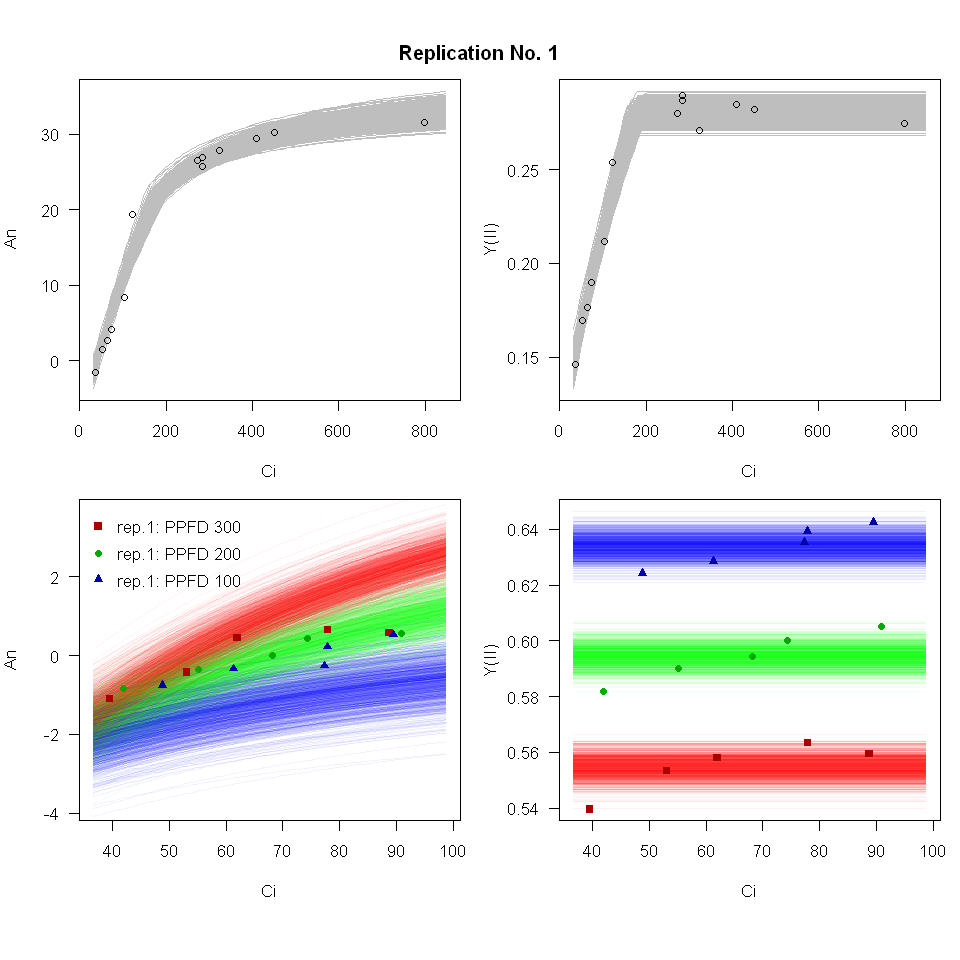

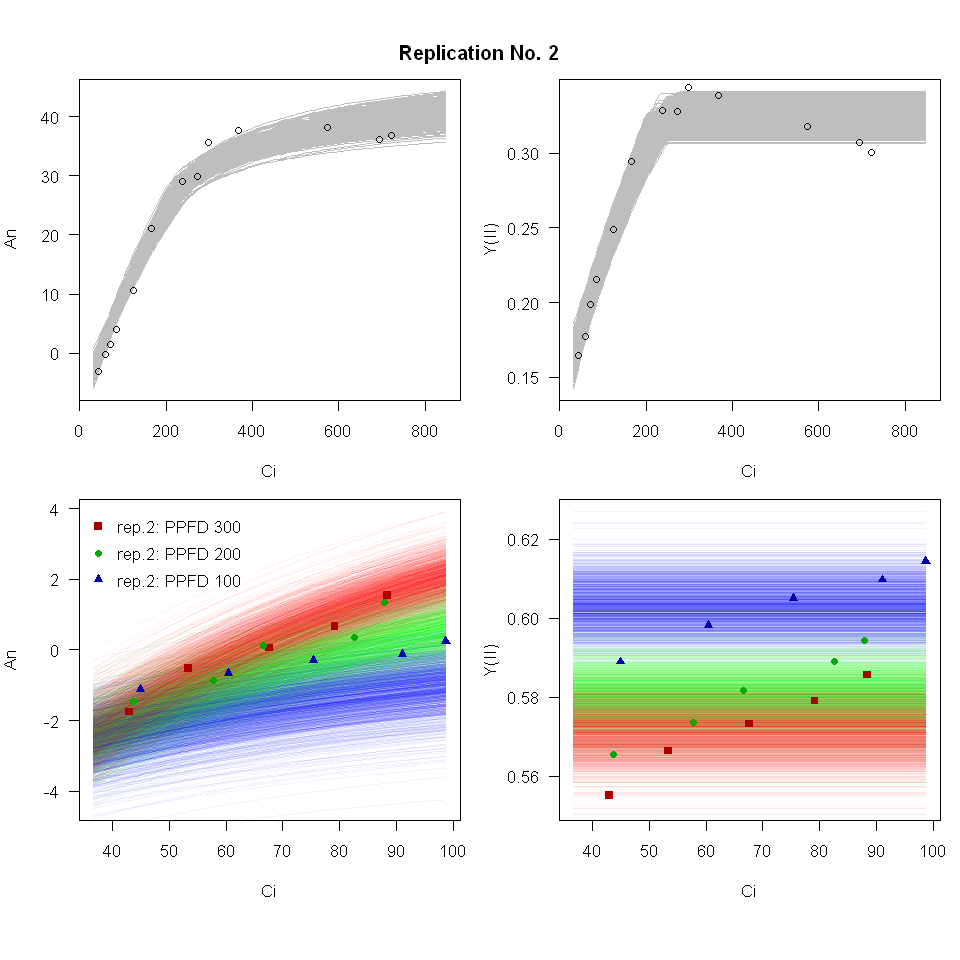

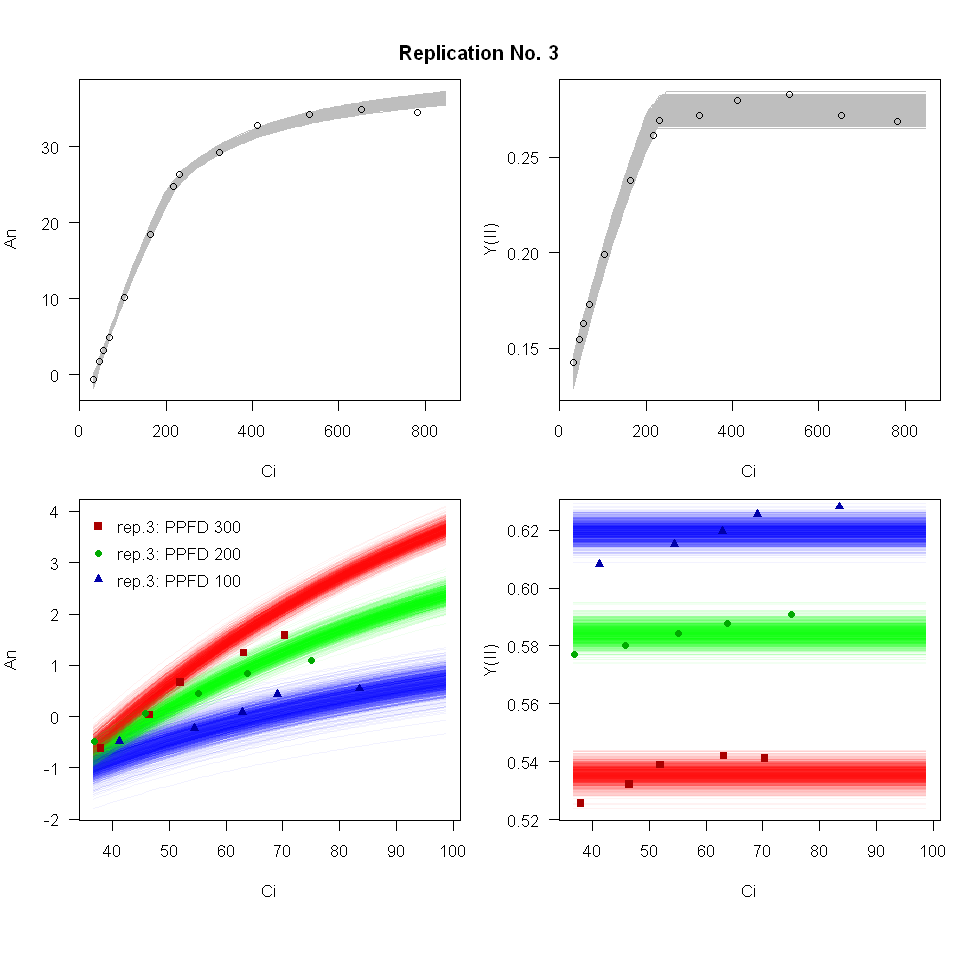

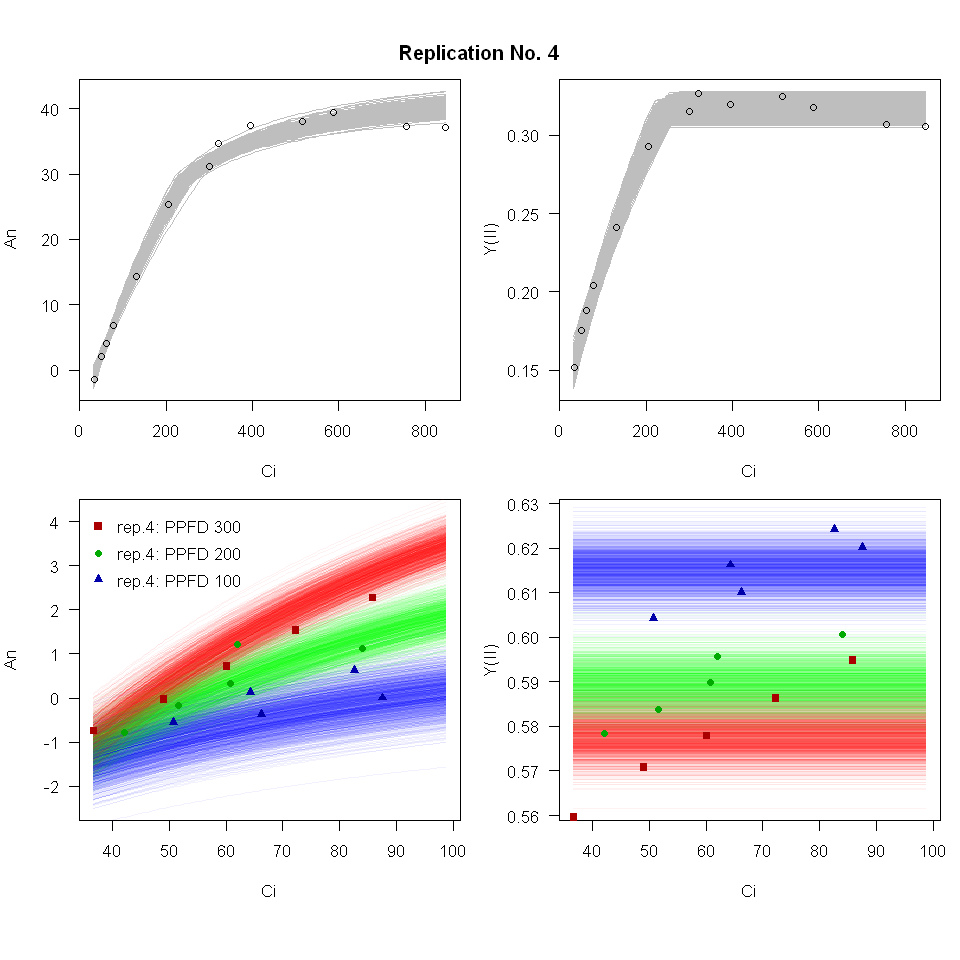

In [15]:
cmap4 <- rainbow(length(PPFDdetected)-1)
tmpcmap4 <- col2rgb(cmap4)/1.5
cmap4darker<- rgb(t(tmpcmap4), maxColorValue=255)
cmap4transparent <- rainbow(length(PPFDdetected)-1, alpha=0.05)
for (looprep2plot in seq(NumRep)) {
    #looprep2plot <- 1
    options(repr.plot.width = 8, repr.plot.height = 8)
    par(mfrow=c(2,2))
    
    tmpxrange1 <- range(unlist(Obs.Ci)[which(Obs.Q==max(PPFDdetected))])#Ci range under saturating light
    lineci1 <- seq(tmpxrange1[1], tmpxrange1[2], length.out=100)
    tmpxrange2 <- range(unlist(Obs.Ci)[which(Obs.Q!=max(PPFDdetected))])#Ci range under low light
    lineci2 <- seq(tmpxrange2[1], tmpxrange2[2], length.out=100)
    
    tmpidxPPFD1 <- which.max(PPFDdetected)
    samples.post1 <- list()
    tmprangeA1 <- list()
    tmprangeyii1 <- list()
    tmpidxPPFD2 <- which(PPFDdetected!=max(PPFDdetected))
    samples.post2 <- list()
    tmprangeA2 <- list()
    tmprangeyii2 <- list()
    
    for (looppost in seq(numsamples2plot)) {# plot all 30000 lines will be slow
        samples.post1[[looppost]] <- FunFvCBgmOPTAYII2ci(lineci1, 
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Vcmax[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Km[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Gstar[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Resp[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$rm[looppost],
                                                         max(PPFDdetected), 
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$J[looppost, tmpidxPPFD1], 
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$s[looppost])
        tmprangeA1[[looppost]] <- range(samples.post1[[looppost]]$A)
        tmprangeyii1[[looppost]] <- range(samples.post1[[looppost]]$yii)
        for (looplightlevel in seq_along(tmpidxPPFD2)) {
            tmpidx2d <- looplightlevel+length(tmpidxPPFD2)*(looppost-1)
            samples.post2[[tmpidx2d]] <- FunFvCBgmOPTAYII2ci(lineci2, 
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Vcmax[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Km[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Gstar[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Resp[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$rm[looppost],
                                                             PPFDdetected[tmpidxPPFD2[looplightlevel]], 
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$J[looppost, tmpidxPPFD2[looplightlevel]], 
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$s[looppost])
            tmprangeA2[[tmpidx2d]] <- range(samples.post2[[looppost]]$A)
            tmprangeyii2[[tmpidx2d]] <- range(samples.post2[[looppost]]$yii)
        }
    }
    
    #A) plot A-Ci under saturating light
    par(mar=c(4,4,4,1))
    for (looppost in seq(numsamples2plot)) {
        if (looppost==1) {
            plot(lineci1, samples.post1[[looppost]]$A, col="gray", type="l",
                 xlim=range(lineci1), ylim=range(tmprangeA1),
                 xlab="Ci", ylab="An", las=1)
        } else {
            lines(lineci1, samples.post1[[looppost]]$A, col="gray")
        }
    }
    tmpCi=na.omit(unlist(Obs.Ci[looprep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[looprep2plot,]))
    tmpA=na.omit(unlist(Obs.A[looprep2plot,]))
    tmpyii=na.omit(unlist(Obs.yii[looprep2plot,]))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    points(tmpCi[tmpidx1],tmpA[tmpidx1],xlab="Ci",ylab="An",las=1)
    #B) plot Y(II)-Ci under saturating light
    par(mar=c(4,4,4,1))
    for (looppost in seq(numsamples2plot)) {
        if (looppost==1) {
            plot(lineci1, samples.post1[[looppost]]$yii, col="gray", type="l",
                 xlim=range(lineci1), ylim=range(tmprangeyii1),
                 xlab="Ci", ylab="Y(II)", las=1)
        } else {
            lines(lineci1, samples.post1[[looppost]]$yii, col="gray")
        }
    }
    points(tmpCi[tmpidx1],tmpyii[tmpidx1],xlab="Ci",ylab="An",las=1)
    #C) plot A-Ci under low lights
    par(mar=c(7,4,1,1))
    for (looppost in seq(numsamples2plot)) {
        for (looplightlevel in seq_along(tmpidxPPFD2)) {
            tmpidx2d <- looplightlevel+length(tmpidxPPFD2)*(looppost-1)
            if (looppost==1 && looplightlevel==1) {
                plot(lineci2, samples.post2[[tmpidx2d]]$A, col=cmap4transparent[looplightlevel], type="l",
                     xlim=range(lineci2), ylim=range(tmprangeA2),
                     xlab="Ci", ylab="An", las=1)
            } else {
                lines(lineci2, samples.post2[[tmpidx2d]]$A, col=cmap4transparent[looplightlevel])
            }
        }
    }
    tmpCi=na.omit(unlist(Obs.Ci[looprep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(Obs.Q[looprep2plot,]))
    tmpA=na.omit(unlist(Obs.A[looprep2plot,]))
    tmpyii=na.omit(unlist(Obs.yii[looprep2plot,]))
    for (looplightlevel in seq_along(tmpidxPPFD2)) {
        tmplowlight=PPFDdetected[tmpidxPPFD2[looplightlevel]]
        tmpidx2=which(tmpQ==tmplowlight)
        points(tmpCi[tmpidx2], tmpA[tmpidx2], pch=looplightlevel+14,
               col=cmap4darker[looplightlevel], las=1)
    }
    legend("topleft",legend = paste("rep.", looprep2plot, ": PPFD ",PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))], sep=""), 
           col=cmap4darker, bty="n", box.lty=0, pch=seq(length(PPFDdetected)-1)+14,
           y.intersp=1, yjust=1)
    #D) plot Y(II)-Ci under low lights
    par(mar=c(7,4,1,1))
    for (looppost in seq(numsamples2plot)) {
        for (looplightlevel in seq_along(tmpidxPPFD2)) {
            tmpidx2d <- looplightlevel+length(tmpidxPPFD2)*(looppost-1)
            if (looppost==1 && looplightlevel==1) {
                plot(lineci2, samples.post2[[tmpidx2d]]$yii, col=cmap4transparent[looplightlevel], type="l",
                     xlim=range(lineci2), ylim=range(tmprangeyii2),
                     xlab="Ci", ylab="Y(II)", las=1)
            } else {
                lines(lineci2, samples.post2[[tmpidx2d]]$yii, col=cmap4transparent[looplightlevel])
            }
        }
    }
    for (looplightlevel in seq_along(tmpidxPPFD2)) {
        tmplowlight=PPFDdetected[tmpidxPPFD2[looplightlevel]]
        tmpidx2=which(tmpQ==tmplowlight)
        points(tmpCi[tmpidx2], tmpyii[tmpidx2], pch=looplightlevel+14,
               col=cmap4darker[looplightlevel],las=1)
    }
    title(paste("Replication No.",looprep2plot), outer=TRUE, line=-3)
    
    ## save plot
    tmpfilename <- paste("s3.3-posterior Ci response curves-rep",looprep2plot,".pdf", sep="")
    tmpstr=paste("rep", looprep2plot, sep="")
    tmpdisp <- dev.copy(pdf, file.path(BayesOPTFolder,OPTFolderName,tmpstr,tmpfilename))
    tmpdisp <- dev.off()
}

## 3.4 Save workspace

In [16]:
## save notebook
# File -> Save as..

## save results to workspace
save.image(file.path(BayesOPTFolder,OPTFolderName,"myfile.RData"))

## Load saved R workspace, then Step 2 can be skipped
#load("./output/myfile.RData")